In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pandas import concat
from pandas import DataFrame
import pickle

In [2]:
new_df = pd.read_csv("Binance_BTCUSDT_1h.csv")
new_df

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USDT,tradecount
0,1.612915e+12,2021-02-10 00:00:00,BTC/USDT,46420.42,46557.24,46052.52,46207.49,639.739914,2.960948e+07,20978.0
1,1.612912e+12,2021-02-09 23:00:00,BTC/USDT,46839.99,46860.00,46201.37,46420.42,2790.416785,1.296341e+08,113106.0
2,1.612908e+12,2021-02-09 22:00:00,BTC/USDT,47241.92,47241.92,46440.52,46839.01,2914.614311,1.363150e+08,105273.0
3,1.612904e+12,2021-02-09 21:00:00,BTC/USDT,47084.16,47461.06,46995.92,47231.03,2564.524939,1.211090e+08,77433.0
4,1.612901e+12,2021-02-09 20:00:00,BTC/USDT,47060.38,47499.43,46668.48,47084.17,3254.702714,1.532251e+08,100788.0
...,...,...,...,...,...,...,...,...,...,...
33184,1.502957e+09,2017-08-17 08-AM,BTC/USDT,4349.99,4377.85,4333.32,4360.69,0.949900,4.139700e+03,NaN
33185,1.502953e+09,2017-08-17 07-AM,BTC/USDT,4324.35,4349.99,4287.41,4349.99,4.440000,1.924106e+04,NaN
33186,1.502950e+09,2017-08-17 06-AM,BTC/USDT,4315.32,4345.45,4309.37,4324.35,7.230000,3.128231e+04,NaN
33187,1.502946e+09,2017-08-17 05-AM,BTC/USDT,4308.83,4328.69,4291.37,4315.32,23.230000,1.003048e+05,NaN


In [3]:
df = new_df.drop(['unix', 'date', 'symbol', 'open', 'high', 'low', 'Volume BTC', 'Volume USDT', 'tradecount'], axis=1)
df

,close
0,46207.49
1,46420.42
2,46839.01
3,47231.03
4,47084.17
...,...
33184,4360.69
33185,4349.99
33186,4324.35
33187,4315.32


In [4]:
sorted_df = df[::-1].reset_index()
df = sorted_df.drop(['index'], axis=1)
df

,close
0,4308.83
1,4315.32
2,4324.35
3,4349.99
4,4360.69
...,...
33184,47084.17
33185,47231.03
33186,46839.01
33187,46420.42


In [5]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [6]:
data = series_to_supervised(df)
data

,var1(t-1),var1(t)
1,4308.83,4315.32
2,4315.32,4324.35
3,4324.35,4349.99
4,4349.99,4360.69
5,4360.69,4444.00
...,...,...
33184,47060.18,47084.17
33185,47084.17,47231.03
33186,47231.03,46839.01
33187,46839.01,46420.42


In [7]:
y = data["var1(t)"].values
x = data.drop("var1(t)",axis=1).values
y_evolution = data["var1(t)"].values
x_evolution = data.drop("var1(t)",axis=1).values

In [8]:
y

array([ 4315.32,  4324.35,  4349.99, ..., 46839.01, 46420.42, 46207.49])

In [9]:
x

array([[ 4308.83],
       [ 4315.32],
       [ 4324.35],
       ...,
       [47231.03],
       [46839.01],
       [46420.42]])

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=10)
len(x_train)

26550

In [11]:
len(x_test)

6638

In [12]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape

(26550, 1)

In [13]:
model = Sequential()

model.add(Dense(500,activation="relu"))
model.add(Dense(500,activation="relu"))
model.add(Dense(500,activation="relu"))
model.add(Dense(500,activation="relu"))
model.add(Dense(500,activation="relu"))
model.add(Dense(500,activation="relu"))
model.add(Dense(500,activation="relu"))
model.add(Dense(500,activation="relu"))
model.add(Dense(500,activation="relu"))

model.add(Dense(1))

model.compile(optimizer="adam",loss="mse")

In [14]:
model.fit(x=x_train, y = y_train,validation_data=(x_test,y_test),epochs=300, batch_size=1000)

Epoch 1/300
27/27 [==============================] - 1s 55ms/step - loss: 84363024.0000 - val_loss: 27840378.0000
Epoch 2/300
27/27 [==============================] - 1s 47ms/step - loss: 7629419.5000 - val_loss: 2209424.5000
Epoch 3/300
27/27 [==============================] - 1s 50ms/step - loss: 430566.6250 - val_loss: 102267.3047
Epoch 4/300
27/27 [==============================] - 1s 48ms/step - loss: 45572.1719 - val_loss: 22932.5996
Epoch 5/300
27/27 [==============================] - 1s 48ms/step - loss: 18802.6484 - val_loss: 17918.8965
Epoch 6/300
27/27 [==============================] - 1s 53ms/step - loss: 16756.0312 - val_loss: 16755.9805
Epoch 7/300
27/27 [==============================] - 1s 50ms/step - loss: 16195.8223 - val_loss: 18155.5586
Epoch 8/300
27/27 [==============================] - 1s 51ms/step - loss: 16099.9541 - val_loss: 15854.2949
Epoch 9/300
27/27 [==============================] - 1s 49ms/step - loss: 15775.3457 - val_loss: 18796.5645
Epoch 10/300
27/

In [ ]:
loss_value = pd.DataFrame(model.history.history)

In [ ]:
loss_value.plot()

In [ ]:
predict_que = model.predict(x_test)
predict_que

In [ ]:
mean_absolute_error(y_test,predict_que)

In [ ]:
plt.scatter(y_test,predict_que)
plt.plot(y_test,y_test,"g-*")

In [ ]:
data.iloc[32900]

In [ ]:
new_prices = data.drop("var1(t)",axis=1).iloc[32900]
new_prices

<AxesSubplot:>

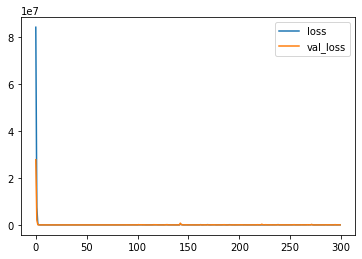

array([[ 9266.758 ],
       [ 6584.8525],
       [ 6340.2637],
       ...,
       [ 8137.492 ],
       [26932.93  ],
       [ 6335.23  ]], dtype=float32)

68.1872089834923

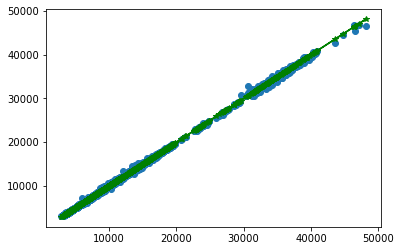

var1(t-1)    34150.23
var1(t)      33906.57
Name: 32901, dtype: float64

var1(t-1)    34150.23
Name: 32901, dtype: float64

array([[0.68983373]])

In [22]:
new_prices = scaler.transform(new_prices.values.reshape(-1,1))
new_prices

In [23]:
model.predict(new_prices)

array([[33982.984]], dtype=float32)

In [24]:
current_price = [[38875]]
current_price = scaler.transform(current_price)
model.predict(current_price)

array([[38681.54]], dtype=float32)

In [25]:
scaled_predict_que =scaler.fit_transform(x)
predicted_que = model.predict(scaled_predict_que)
predicted_que

array([[ 4476.2812],
       [ 4482.6963],
       [ 4491.621 ],
       ...,
       [46994.715 ],
       [46606.43  ],
       [46191.83  ]], dtype=float32)

In [26]:
values_correct = 0
values_incorrect = 0
for a in range(6637):
  if y_evolution[a] > x_evolution[a] and predicted_que[a] > x_evolution[a]:
    values_correct += 1
  elif y_evolution[a] < x_evolution[a] and predicted_que[a] < x_evolution[a]:
    values_correct += 1
  else:
    values_incorrect += 1
print("Dogru bilinen sayisi ->{}".format(values_correct))
print("Yanlis bilinen sayisi ->{}".format(values_incorrect))
print("Accuracy->{}".format(float(values_correct)/6637))

Dogru bilinen sayisi ->3433
Yanlis bilinen sayisi ->3204
Accuracy->0.5172517703781829


In [27]:
import dill
import weakref


In [28]:
pkl_filename = "pickle_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)

TypeError: cannot pickle '_thread.RLock' object